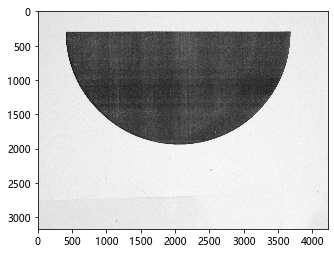

In [2]:
import numpy as np
from PIL import Image
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage import morphology
from scipy import ndimage
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

img_path = './images/DSC00322.JPG'
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(1)
plt.imshow(gray, cmap='gray')
plt.show()
plt.close(1)

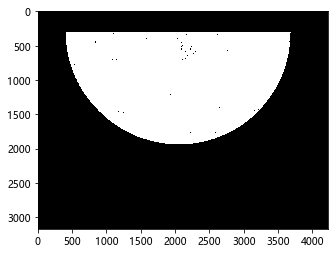

In [3]:
ret, BW = cv2.threshold(gray, 100, 1, cv2.THRESH_BINARY)
plt.figure(2)
plt.imshow(BW, cmap='binary')
plt.show()
plt.close(2)

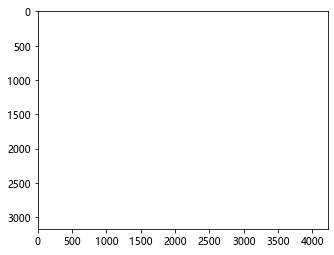

In [4]:
from scipy import ndimage
BW = ndimage.binary_fill_holes(BW).astype(np.uint8)
plt.figure(3)
plt.imshow(BW, cmap='binary')
plt.show()
plt.close(3)

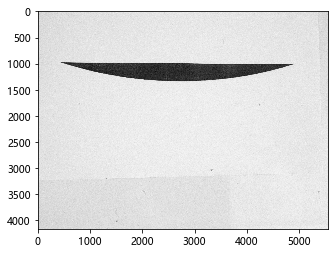

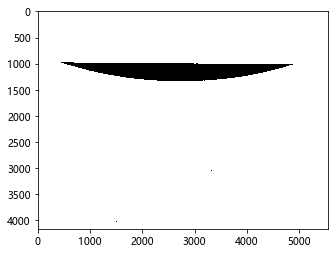

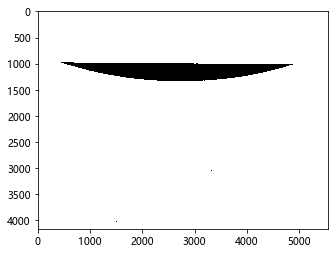

最大像素点为4870，最小像素点为433，共有像素点为4437


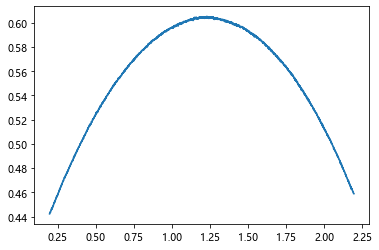

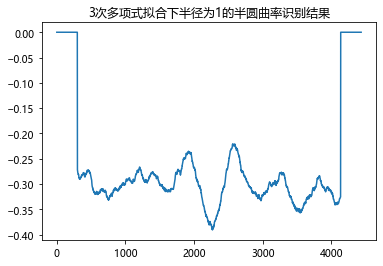

In [2]:
import numpy as np
from PIL import Image
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage import morphology
from scipy import ndimage
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

img_path = './images/DSC00313.JPG'  # 1200万像素
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(1)
plt.imshow(gray, cmap='gray')
plt.show()
plt.close(1)
ret, BW = cv2.threshold(gray, 120, 1, cv2.THRESH_BINARY)
BW = (BW == 0)  # 把图像黑白对调
plt.figure(2)
plt.imshow(BW, cmap='binary')
plt.show()
plt.close(2)

BW = ndimage.binary_fill_holes(BW).astype(np.uint8)
plt.figure(3)
plt.imshow(BW, cmap='binary')
plt.show()
plt.close(3)

(H, W) = BW.shape[:2]
area = H * W  # 图片面积
discard = 0.001  # 丢弃面积率
BW = morphology.remove_small_objects(BW > 0, discard*area, connectivity=2)
BW = BW.astype(np.uint8)

# 提取边缘
y, x = np.where(BW == 1)
df = pd.DataFrame({'x': x, 'y': y})
data_group = df.groupby(['x']).max()
data_group.index.name = 'index'
data_group['x'] = data_group.index
data_group.sort_values('x', ascending=True, inplace=True)
x = np.array(data_group['x']).astype(np.int)
y = np.array(data_group['y']).astype(np.int)
print("最大像素点为{}，最小像素点为{}，共有像素点为{}".format(max(x),min(x),max(x)-min(x)))

# 提取比例因子
factor = 2/(max(x) - min(x))

# 计算曲率
x = x * factor
y = y * factor
plt.figure(2)
plt.plot(x, y)
plt.show()
plt.close(2)

length = len(x)
delta = 300
K = np.zeros(length)

# 全部3274个像素，取局部600个像素
for i in range(delta, length-delta):
    # 2次多项式
    # c0 = np.polyfit(x[i - delta:i + delta], y[i - delta:i + delta], 2)
    # c1 = np.array([c0[0]*2, c0[1]*1])
    # c2 = np.array([c1[1]])

    # 3次多项式
    c0 = np.polyfit(x[i - delta:i + delta], y[i - delta:i + delta], 3)  # 挠曲线系数
    c1 = np.array([c0[0] * 3, c0[1] * 2, c0[2]])  # 1阶导函数系数
    c2 = np.array([c1[0] * 2, c1[1]])  # 2阶导函数系数

    # 4次多项式
    # c0 = np.polyfit(x[i - delta:i + delta], y[i - delta:i + delta], 4)  # 挠曲线系数
    # c1 = np.array([c0[0] * 4, c0[1] * 3, c0[2]*2])  # 1阶导函数系数
    # c2 = np.array([c1[0] * 3, c1[1]*2])  # 2阶导函数系数

    Y = np.poly1d(c0)
    ddy = np.poly1d(c2)
    dy = np.poly1d(c1)
    # y0[i] = Y(x[i])
    K[i] = ddy(x[i]) / ((1 + dy(x[i]) ** 2) ** (3 / 2))

plt.figure(4)
s = np.array(range(length))
plt.plot(s, K)
plt.title('3次多项式拟合下半径为1的半圆曲率识别结果')
plt.savefig('semicircle_3.png', dpi=1080)
plt.show()
plt.close(4)